# **Cats vs Dogs Semantic Segmentation**

## **Start by downloading and uncompressing our dataset**

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2025-08-19 09:24:07--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-08-19 09:24:08--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-08-19 09:24:08--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

URL transformed to HTTPS due to an HSTS policy
--2025-08-19 09:25:42--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/annotations.tar.gz [following]
--2025-08-19 09:25:43--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  6.79MB/s    in 2.7s    

2025-08-19 09:25:47 (6.79 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [ ]:
!tar -xf images.tar.gz

In [ ]:
!tar -xf annotations.tar.gz

## **Prepare the list of input file paths**

In [ ]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps"

input_img_paths = sorted([os.path.join(input_dir, fname)
                          for fname in os.listdir(input_dir)
                              if fname.endswith(".jpg")])


target_paths = sorted([os.path.join(target_dir, fname)
                        for fname in os.listdir(target_dir)
                            if fname.endswith(".png") and not fname.startswith(".")])

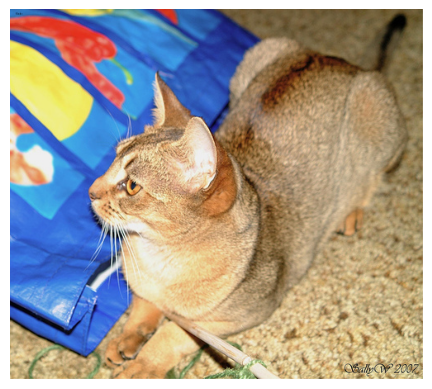

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

In [ ]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

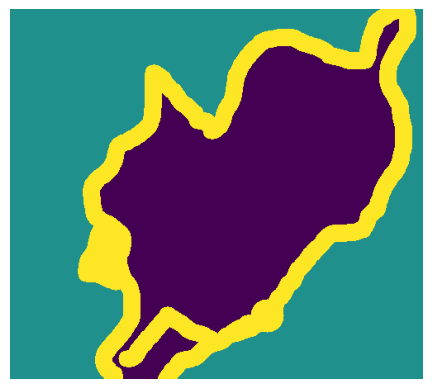

In [ ]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

## **Dataset Preparation and Preprocessing**

### **load our inputs and targets into two NumPy arrays and split the arrays into a training and a validation set**

In [ ]:
import numpy as np
import random

img_size = (200,200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## **Model Scratch**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)       # Don't forget to rescale input images to the [0,1] range

  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
      256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
      128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
      64, 3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation="softmax",
                          padding="same")(x)

  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

## **Compile, Callbacks, and Model Fit**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

history = model.fit(train_input_imgs, train_targets,
                    validation_data=(val_input_imgs, val_targets),
                    epochs=50,
                    batch_size=64,
                    callbacks=callbacks)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - loss: 1.0916 - val_loss: 0.9849 - learning_rate: 1.0000e-05
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 110s 553ms/step - loss: 0.9836 - val_loss: 0.9642 - learning_rate: 1.0000e-05
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 555ms/step - loss: 0.9593 - val_loss: 0.8991 - learning_rate: 1.0000e-05
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 548ms/step - loss: 0.8715 - val_loss: 0.8173 - learning_rate: 1.0000e-05
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 560ms/step - loss: 0.8121 - val_loss: 0.7847 - learning_rate: 1.0000e-05
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 573ms/step - loss: 0.7756 - val_loss: 0.7595 - learning_rate: 1.0000e-05
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - loss: 0.7587 - val_loss: 0.7445 - learning_rate: 1.0000e-05
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 558ms/step - loss: 0.7459 - val_loss: 0.7333 - learning_rate: 1.0000e-05
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 553ms/step - loss: 0.

## **Training Loss and Validation Loss Graphs**

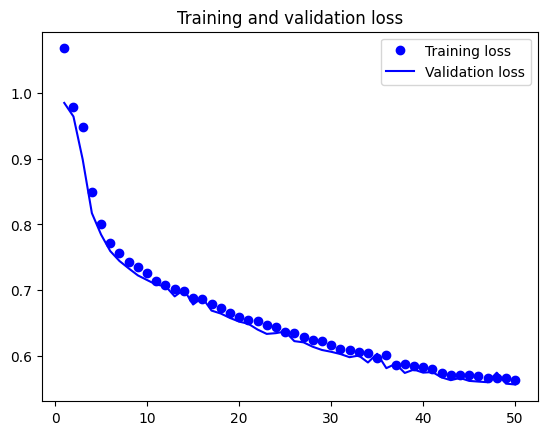

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

## **Testing Predictions (Inference)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


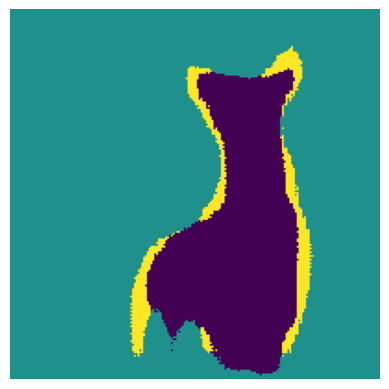

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("/content/oxford_segmentation.keras")
i = 1
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

display_mask(mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


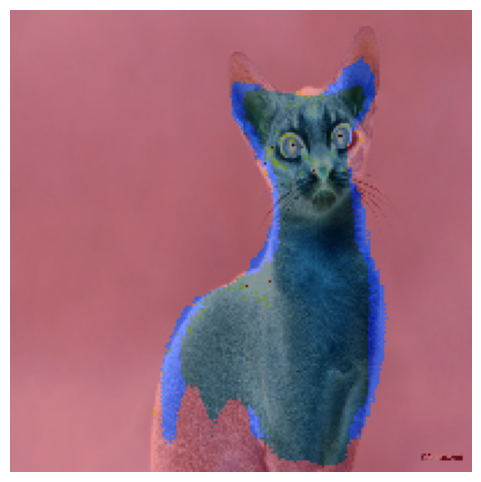

In [ ]:
import matplotlib.pyplot as plt

def display_mask_overlay(image, mask_pred):
    # Pixel-wise class prediction
    mask = np.argmax(mask_pred, axis=-1)

    # Create a color mask (3 channels)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Define colors: background=black, cat=red, dog=blue
    color_mask[mask == 1] = [255, 0, 0]   # Red for cat
    color_mask[mask == 2] = [0, 0, 255]   # Blue for dog

    # Convert input image to uint8
    img_uint8 = (image * 255).astype(np.uint8)

    # Overlay mask on original image
    overlay = (0.6 * img_uint8 + 0.4 * color_mask).astype(np.uint8)

    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(overlay)
    plt.show()

# Example usage:
i = 1
test_image = val_input_imgs[i]
mask_pred = model.predict(np.expand_dims(test_image, 0))[0]

display_mask_overlay(test_image, mask_pred)

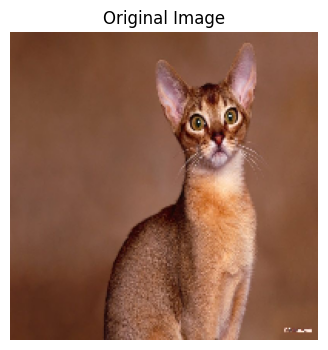

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


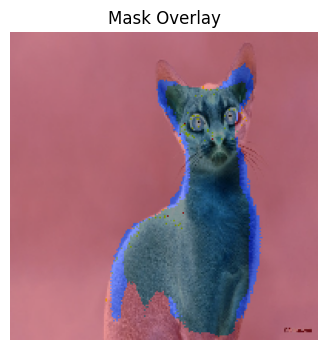

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
from tensorflow import keras

# Load trained model
model = keras.models.load_model("/content/oxford_segmentation.keras")

# Select a test image (validation set)
i = 1
test_image = val_input_imgs[i]

plt.figure(figsize=(4,4))
plt.title("Original Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.show()

# Predict mask
mask_pred = model.predict(np.expand_dims(test_image, 0))[0]

# Overlay mask on image
def display_mask_overlay(image, mask_pred):
    mask = np.argmax(mask_pred, axis=-1)

    # Color mask: background=black, cat=red, dog=blue
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == 1] = [255, 0, 0]   # Cat = Red
    color_mask[mask == 2] = [0, 0, 255]   # Dog = Blue

    img_uint8 = (image * 255).astype(np.uint8)
    overlay = (0.6 * img_uint8 + 0.4 * color_mask).astype(np.uint8)

    plt.figure(figsize=(4,4))
    plt.title("Mask Overlay")
    plt.axis("off")
    plt.imshow(overlay)
    plt.show()

display_mask_overlay(test_image, mask_pred)


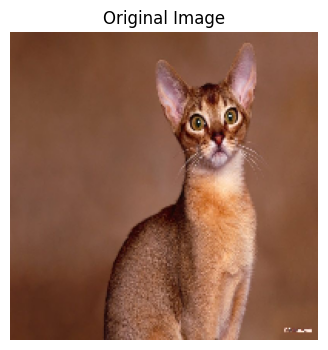

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


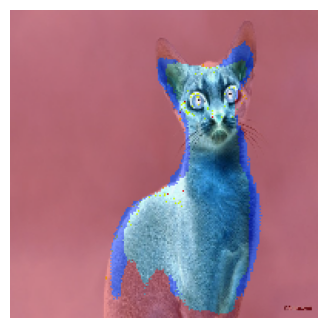

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
from tensorflow import keras

# Load trained model
model = keras.models.load_model("/content/oxford_segmentation.keras")

# Select a test image (validation set)
i = 1
test_image = val_input_imgs[i]

plt.figure(figsize=(4,4))
plt.title("Original Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.show()

# Predict mask
mask_pred = model.predict(np.expand_dims(test_image, 0))[0]


def display_mask_overlay(image, mask_pred):
    mask = np.argmax(mask_pred, axis=-1)

    # Color mask
    color_mask = np.zeros_like(image, dtype=np.uint8)
    color_mask[mask == 1] = [255, 0, 0]   # Cat = Red
    color_mask[mask == 2] = [0, 0, 255]   # Dog = Blue

    img_uint8 = (image * 255).astype(np.uint8)

    # Only apply mask where mask != 0
    overlay = img_uint8.copy()
    overlay[mask != 0] = (0.6 * img_uint8[mask != 0] + 0.4 * color_mask[mask != 0]).astype(np.uint8)

    plt.figure(figsize=(4,4))
    plt.axis("off")
    plt.imshow(overlay)
    plt.show()

display_mask_overlay(test_image, mask_pred)